<a href="https://colab.research.google.com/github/Arokiarajan1/Arokiabackup/blob/main/DuckSpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Define data size

sf1 = 6 Millions Rows, Complex data model with 8 Tables

In [ ]:
sf=10

# Install Package

In [ ]:
!pip install duckdb --pre --upgrade                > /dev/null 2>&1
!pip install pyspark                               > /dev/null 2>&1

In [ ]:
!pip show duckdb
!pip show pyspark

Name: duckdb
Version: 0.9.1
Summary: DuckDB embedded database
Home-page: https://www.duckdb.org
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: 
Name: pyspark
Version: 3.5.0
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: py4j
Required-by: 


# Generate Parquet files

In [ ]:
%%time
import duckdb
import pathlib
for x in range(0, sf) :
  con=duckdb.connect()
  con.sql('PRAGMA disable_progress_bar;SET preserve_insertion_order=false')
  con.sql(f"CALL dbgen(sf={sf} , children ={sf}, step = {x})")
  for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
     pathlib.Path(f'{sf}/{tbl}').mkdir(parents=True, exist_ok=True)
     con.sql(f"COPY (SELECT * FROM {tbl}) TO '{sf}/{tbl}/{x:02d}.parquet' ")
  con.close()

CPU times: user 4min 24s, sys: 9.78 s, total: 4min 34s
Wall time: 3min 29s


# SQL Query

In [ ]:
# @title
sql=(f'''
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;


SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;







SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;








SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;








SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;







SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;







SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;




select
--Query08
    o_year,
    cast(cast(sum(case
                      when nation = 'BRAZIL' then volume
                      else 0
        end) as decimal(12,2)) / cast(sum(volume) as decimal(12,2)) as decimal(15,2)) as mkt_share
from
    (
        select
            extract(year from o_orderdate) as o_year,
            l_extendedprice * (1 - l_discount) as volume,
            n2.n_name as nation
        from
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        where
                p_partkey = l_partkey
          and s_suppkey = l_suppkey
          and l_orderkey = o_orderkey
          and o_custkey = c_custkey
          and c_nationkey = n1.n_nationkey
          and n1.n_regionkey = r_regionkey
          and r_name = 'AMERICA'
          and s_nationkey = n2.n_nationkey
          and o_orderdate between date '1995-01-01' and date '1996-12-31'
          and p_type = 'ECONOMY ANODIZED STEEL'
    ) as all_nations
group by
    o_year
order by
    o_year;



SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;








SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;







SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * (0.0001/{sf})
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;








SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;








SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;








SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);








SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            supplier_no
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    l_suppkey
            ) revenue1
    )
ORDER BY
    s_suppkey;








SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;








SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );






SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;





SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );






SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;






SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;






SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;

''')

# Print Duration

In [ ]:
# @title
%%time
import time
import pandas as pd
pd.set_option('display.max_columns', 20)
def execute_query(engine, sql_script):
    df = pd.DataFrame(columns=['dur','query'])
    sql_arr = sql_script.split(";")
    for index, value in enumerate(sql_arr,start=1):
        if len(value.strip()) > 0:
            start = time.time()
            print('Query' + str(index))
            try :
             engine.sql(value).show()
             stop = time.time()
             duration = stop-start
            except  Exception as er:
              print(er)
              duration =0
            print(duration)
            row = {'dur': duration,'query':index}
            df = pd.concat([df,pd.DataFrame(row, index=[index])], axis=0, ignore_index=True)
    return df

CPU times: user 231 ms, sys: 17 ms, total: 248 ms
Wall time: 250 ms


***Add folder to store results***

In [ ]:
# @title
import os
if not os.path.exists(os.getcwd() + '/' + 'result'):
    os.makedirs(os.getcwd() + '/' + 'result', exist_ok=True)

# ---------------------

# DuckSpark

In [ ]:
%%time
import duckdb
from duckdb.experimental.spark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
    spark.read.parquet(f'./{sf}/{tbl}/*.parquet').createOrReplaceTempView(tbl)
duck_import=execute_query(spark, sql)
duck_import.to_csv ('./result/duck_import.csv', index = None, header=True)

Query1


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌──────────────┬──────────────┬───────────────┬───┬────────────────────┬─────────────────────┬─────────────┐
│ l_returnflag │ l_linestatus │    sum_qty    │ … │     avg_price      │      avg_disc       │ count_order │
│   varchar    │   varchar    │ decimal(38,2) │   │       double       │       double        │    int64    │
├──────────────┼──────────────┼───────────────┼───┼────────────────────┼─────────────────────┼─────────────┤
│ A            │ F            │  377518399.00 │ … │  38237.15100895854 │  0.0500065745402432 │    14804077 │
│ N            │ F            │    9851614.00 │ … │  38257.81066008114 │ 0.04997336773765667 │      385998 │
│ N            │ O            │  743124873.00 │ … │  38233.90292348181 │ 0.05000081182113131 │    29144351 │
│ R            │ F            │  377732830.00 │ … │ 38251.219273559764 │ 0.04999679231408742 │    14808183 │
├──────────────┴──────────────┴───────────────┴───┴────────────────────┴─────────────────────┴─────────────┤
│ 4 rows           

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬───────────────┬─────────────┬────────────────┐
│ l_orderkey │    revenue    │ o_orderdate │ o_shippriority │
│   int32    │ decimal(38,4) │    date     │     int32      │
├────────────┼───────────────┼─────────────┼────────────────┤
│    4791171 │   440715.2185 │ 1995-02-23  │              0 │
│   46678469 │   439855.3250 │ 1995-01-27  │              0 │
│   23906758 │   432728.5737 │ 1995-03-14  │              0 │
│   23861382 │   428739.1368 │ 1995-03-09  │              0 │
│   59393639 │   426036.0662 │ 1995-02-12  │              0 │
│    3355202 │   425100.6657 │ 1995-03-04  │              0 │
│    9806272 │   425088.0568 │ 1995-03-13  │              0 │
│   22810436 │   423231.9690 │ 1995-01-02  │              0 │
│   16384100 │   421478.7294 │ 1995-03-02  │              0 │
│   52974151 │   415367.1195 │ 1995-02-05  │              0 │
├────────────┴───────────────┴─────────────┴────────────────┤
│ 10 rows                                         4 columns │
└───────

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────┬─────────────┐
│ o_orderpriority │ order_count │
│     varchar     │    int64    │
├─────────────────┼─────────────┤
│ 1-URGENT        │      105214 │
│ 2-HIGH          │      104821 │
│ 3-MEDIUM        │      105227 │
│ 4-NOT SPECIFIED │      105422 │
│ 5-LOW           │      105356 │
└─────────────────┴─────────────┘

6.896547555923462
Query5


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────┐
│  n_name   │    revenue     │
│  varchar  │ decimal(38,4)  │
├───────────┼────────────────┤
│ INDIA     │ 536862587.9995 │
│ CHINA     │ 535350829.9282 │
│ VIETNAM   │ 532269388.7176 │
│ JAPAN     │ 526766837.1444 │
│ INDONESIA │ 523176852.3189 │
└───────────┴────────────────┘

5.227820634841919
Query6


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────────┐
│     revenue     │
│  decimal(38,4)  │
├─────────────────┤
│ 1230113636.0101 │
└─────────────────┘

4.752963542938232
Query7


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────────┬─────────────┬────────┬────────────────┐
│ supp_nation │ cust_nation │ l_year │    revenue     │
│   varchar   │   varchar   │ int64  │ decimal(38,4)  │
├─────────────┼─────────────┼────────┼────────────────┤
│ FRANCE      │ GERMANY     │   1995 │ 521960141.7003 │
│ FRANCE      │ GERMANY     │   1996 │ 524796110.3842 │
│ GERMANY     │ FRANCE      │   1995 │ 542199700.0546 │
│ GERMANY     │ FRANCE      │   1996 │ 533640926.2614 │
└─────────────┴─────────────┴────────┴────────────────┘

15.795406579971313
Query8


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────┬───────────────┐
│ o_year │   mkt_share   │
│ int64  │ decimal(15,2) │
├────────┼───────────────┤
│   1995 │          0.04 │
│   1996 │          0.04 │
└────────┴───────────────┘

6.130401134490967
Query9


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┬────────┬────────────────┐
│    nation     │ o_year │   sum_profit   │
│    varchar    │ int64  │ decimal(38,4)  │
├───────────────┼────────┼────────────────┤
│ ALGERIA       │   1998 │ 271504046.5508 │
│ ALGERIA       │   1997 │ 457035986.9555 │
│ ALGERIA       │   1996 │ 457125199.0414 │
│ ALGERIA       │   1995 │ 460972497.0491 │
│ ALGERIA       │   1994 │ 456444975.7127 │
│ ALGERIA       │   1993 │ 456449926.4138 │
│ ALGERIA       │   1992 │ 459548354.7680 │
│ ARGENTINA     │   1998 │ 277792984.9141 │
│ ARGENTINA     │   1997 │ 467555914.5594 │
│ ARGENTINA     │   1996 │ 473886192.7453 │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│     ·         │     ·  │        ·       │
│ UNITED STATES │   1994 │ 476447816.2560 │
│ UNITED STATES │   1993 │ 460120427.2978 │
│ UNITED STATES │   1992 │ 468157792.3023 │
│ VIETNAM       │   1998 │ 272979518.3274 │
│ VIETNAM       │   1997 │ 473777590.7684 │
│ VIETNAM       │   1996 │ 46604

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬───────────────┬───┬──────────────────────┬─────────────────┬──────────────────────┐
│ c_custkey │       c_name       │    revenue    │ … │      c_address       │     c_phone     │      c_comment       │
│   int32   │      varchar       │ decimal(38,4) │   │       varchar        │     varchar     │       varchar        │
├───────────┼────────────────────┼───────────────┼───┼──────────────────────┼─────────────────┼──────────────────────┤
│   1237537 │ Customer#001237537 │   884989.6657 │ … │ mdkU4LpZECCtt20RHa…  │ 32-367-120-4327 │ yly regular accoun…  │
│   1116802 │ Customer#001116802 │   830214.1117 │ … │ iBka7YijCCLApX1f 8…  │ 23-199-655-3770 │ y carefully regula…  │
│    508954 │ Customer#000508954 │   826167.5138 │ … │ tKQLmGq3MOqXiTmNZQRp │ 15-880-510-9487 │ t the quickly pend…  │
│   1487503 │ Customer#001487503 │   825996.5903 │ … │ D tOJIC0rcVO         │ 20-271-234-4401 │ ithely quiet depos…  │
│   1461247 │ Customer#001461247 │   775992.0820

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────┬─────────────────┬────────────────┐
│ l_shipmode │ high_line_count │ low_line_count │
│  varchar   │     int128      │     int128     │
├────────────┼─────────────────┼────────────────┤
│ MAIL       │           62071 │          93045 │
│ SHIP       │           62426 │          93261 │
└────────────┴─────────────────┴────────────────┘

8.812001466751099
Query13


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌─────────┬──────────┐
│ c_count │ custdist │
│  int64  │  int64   │
├─────────┼──────────┤
│       0 │   500019 │
│      10 │    66125 │
│       9 │    65012 │
│      11 │    62192 │
│       8 │    58445 │
│      12 │    55784 │
│      13 │    49943 │
│      19 │    46595 │
│       7 │    46529 │
│      18 │    46036 │
│       · │       ·  │
│       · │       ·  │
│       · │       ·  │
│       1 │      232 │
│      36 │      144 │
│      37 │       83 │
│      38 │       47 │
│      39 │       16 │
│      40 │        9 │
│      41 │        7 │
│      42 │        4 │
│      43 │        3 │
│      46 │        1 │
├─────────┴──────────┤
│ 45 rows (20 shown) │
└────────────────────┘

7.646830797195435
Query14


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┐
│   promo_revenue    │
│       double       │
├────────────────────┤
│ 16.647594941615097 │
└────────────────────┘

4.294068813323975
Query15


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────┬────────────────────┬──────────────────────────────────────────┬─────────────────┬───────────────┐
│ s_suppkey │       s_name       │                s_address                 │     s_phone     │ total_revenue │
│   int32   │      varchar       │                 varchar                  │     varchar     │ decimal(38,4) │
├───────────┼────────────────────┼──────────────────────────────────────────┼─────────────────┼───────────────┤
│     69998 │ Supplier#000069998 │ 117W54YtKASNfzkZRS8P32856BMj0HKf895vdukw │ 16-386-278-9829 │  2194132.8166 │
└───────────┴────────────────────┴──────────────────────────────────────────┴─────────────────┴───────────────┘

7.99219274520874
Query16
┌──────────┬───────────────────────────┬────────┬──────────────┐
│ p_brand  │          p_type           │ p_size │ supplier_cnt │
│ varchar  │          varchar          │ int32  │    int64     │
├──────────┼───────────────────────────┼────────┼──────────────┤
│ Brand#44 │ STANDARD PLATED TIN       │  

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────────┐
│    avg_yearly     │
│      double       │
├───────────────────┤
│ 3295493.512857143 │
└───────────────────┘

11.756163120269775
Query18


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬───────────┬────────────┬─────────────┬───────────────┬─────────────────┐
│       c_name       │ c_custkey │ o_orderkey │ o_orderdate │ o_totalprice  │ sum(l_quantity) │
│      varchar       │   int32   │   int32    │    date     │ decimal(15,2) │  decimal(38,2)  │
├────────────────────┼───────────┼────────────┼─────────────┼───────────────┼─────────────────┤
│ Customer#001287812 │   1287812 │   42290181 │ 1997-11-26  │     558289.17 │          318.00 │
│ Customer#000644812 │    644812 │    2745894 │ 1996-07-04  │     557664.53 │          304.00 │
│ Customer#001172513 │   1172513 │   36667107 │ 1997-06-06  │     550142.18 │          322.00 │
│ Customer#000399481 │    399481 │   43906817 │ 1995-04-06  │     549431.65 │          312.00 │
│ Customer#000571654 │    571654 │   21213895 │ 1992-01-03  │     549380.08 │          327.00 │
│ Customer#000667882 │    667882 │    2199712 │ 1996-09-30  │     542154.01 │          327.00 │
│ Customer#001492954 │   1492954 │   303

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌───────────────┐
│    revenue    │
│ decimal(38,4) │
├───────────────┤
│ 30104438.0911 │
└───────────────┘

8.468728303909302
Query20


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬────────────────────────────────────┐
│       s_name       │             s_address              │
│      varchar       │              varchar               │
├────────────────────┼────────────────────────────────────┤
│ Supplier#000000020 │ JtPqm19E7tF 152Rl1wQZ8j0H          │
│ Supplier#000000285 │ q TMZEDyZtv vUiFKBhT3NJlnIxpL      │
│ Supplier#000000358 │ 6XtuJkJj83BcCOV7bwV7wG5nkhazk      │
│ Supplier#000000361 │ MSi62aEN53KaoRAiaH4GEo3EsKMXSwpPGU │
│ Supplier#000000402 │ JR8vWoCteJtJg3okRpt0r28KEo         │
│ Supplier#000000555 │ 8Lp0QWPLFXrJrX1sTWkAEdzUsh5ke      │
│ Supplier#000000688 │ orLvVDOBBE2B2ppjbiTZTJoIJgn1VgKg3  │
│ Supplier#000000729 │ CAOGYCBtTVT7aB1p6qHbxF6VVhXaHLgTpI │
│ Supplier#000000744 │ WdgxvW4WEloeapP7H6cWHrGLCHkStwrM   │
│ Supplier#000000752 │ GrOjezmDCNvHXl5                    │
│         ·          │        ·                           │
│         ·          │        ·                           │
│         ·          │        ·         

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

┌────────────────────┬─────────┐
│       s_name       │ numwait │
│      varchar       │  int64  │
├────────────────────┼─────────┤
│ Supplier#000062538 │      24 │
│ Supplier#000032858 │      22 │
│ Supplier#000063723 │      21 │
│ Supplier#000089484 │      21 │
│ Supplier#000007061 │      20 │
│ Supplier#000034162 │      20 │
│ Supplier#000086690 │      20 │
│ Supplier#000097808 │      20 │
│ Supplier#000004163 │      19 │
│ Supplier#000016074 │      19 │
│         ·          │       · │
│         ·          │       · │
│         ·          │       · │
│ Supplier#000099320 │      17 │
│ Supplier#000099325 │      17 │
│ Supplier#000000114 │      16 │
│ Supplier#000000821 │      16 │
│ Supplier#000004199 │      16 │
│ Supplier#000006757 │      16 │
│ Supplier#000006795 │      16 │
│ Supplier#000006824 │      16 │
│ Supplier#000007491 │      16 │
│ Supplier#000008301 │      16 │
├────────────────────┴─────────┤
│     100 rows (20 shown)      │
└──────────────────────────────┘

20.676863

# Spark

In [ ]:
%%time
import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"
import pyspark as spark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName("PySpark Read Parquet").getOrCreate()
for tbl in ['nation','region','customer','supplier','lineitem','orders','partsupp','part'] :
  spark.read.parquet(f'./{sf}/{tbl}/*.parquet').createOrReplaceTempView(tbl)
apachespark=execute_query(spark, sql)
apachespark.to_csv ('./result/apachespark.csv', index = None, header=True)

Query1
+------------+------------+------------+----------------+------------------+--------------------+---------+------------+--------+-----------+
|l_returnflag|l_linestatus|     sum_qty|  sum_base_price|    sum_disc_price|          sum_charge|  avg_qty|   avg_price|avg_disc|count_order|
+------------+------------+------------+----------------+------------------+--------------------+---------+------------+--------+-----------+
|           A|           F|377518399.00| 566065727797.25| 537759104278.0656| 559276670892.116819|25.500975|38237.151009|0.050007|   14804077|
|           N|           F|  9851614.00|  14767438399.17|  14028805792.2114|  14590490998.366737|25.522448|38257.810660|0.049973|     385998|
|           N|           O|743124873.00|1114302286901.88|1058580922144.9638|1100937000170.591854|25.498076|38233.902923|0.050001|   29144351|
|           R|           F|377732830.00| 566431054976.00| 538110922664.7677| 559634780885.086257|25.508385|38251.219274|0.049997|   14808183|

# --------------------------

# Collect Data

In [ ]:
duck_import    = pd.read_csv('./result/duck_import.csv')

apachespark    = pd.read_csv('./result/apachespark.csv')


concat = duckdb.sql('''select duck_import.query  as query,
duck_import.dur as DuckSpark , apachespark.dur as apachespark
from duck_import

left join apachespark
on duck_import.query=apachespark.query

''').df()
concat

,query,DuckSpark,apachespark
0,1,17.375246,103.071292
1,2,2.533508,13.985459
2,3,6.042346,36.557114
3,4,6.896548,25.781459
4,5,5.227821,50.498583
5,6,4.752964,6.145957
6,7,15.795407,45.669209
7,8,6.130401,12.365321
8,9,22.866033,42.252471
9,10,8.662261,26.262344


In [ ]:
result = concat[['query','DuckSpark','apachespark']]
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = 'Parquet TPCH-SF'+str(sf)+' ,Notebook, '+vCPU+' '+str(mem)+'GB, Run time : '+ str(time.strftime("%Y-%m-%d")) \
+ ', Total Duration (second) : DuckSpark '+str(round(result['DuckSpark'].sum(),2))\
+', apachespark '+str(round(result['apachespark'].sum(),2))

# Result

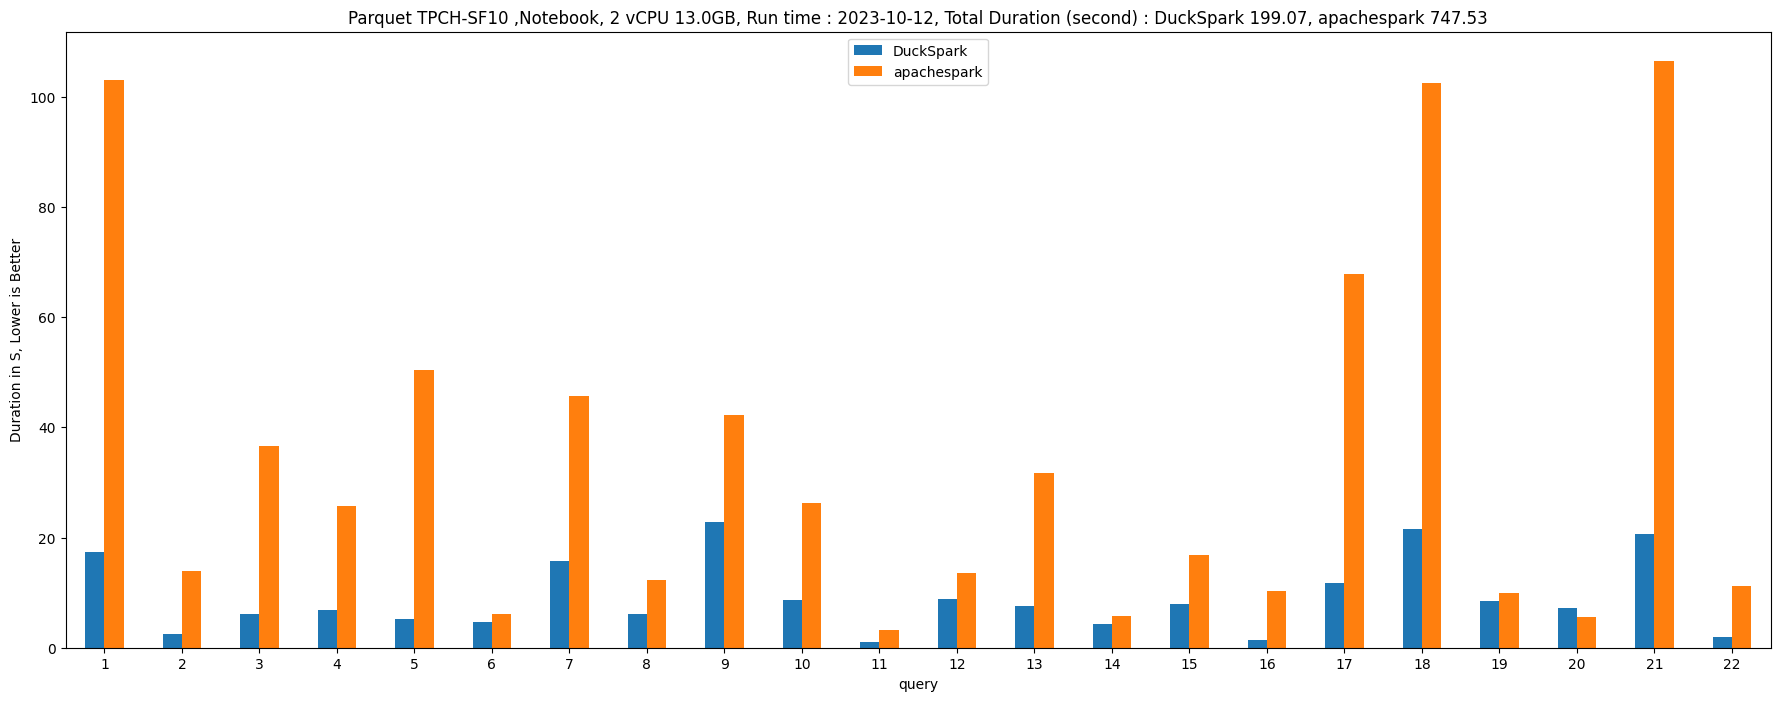

In [ ]:
ax = result.plot.bar(rot=0,x='query',y=['DuckSpark','apachespark'],title=runtime,ylabel='Duration in S, Lower is Better',figsize=(22,8))

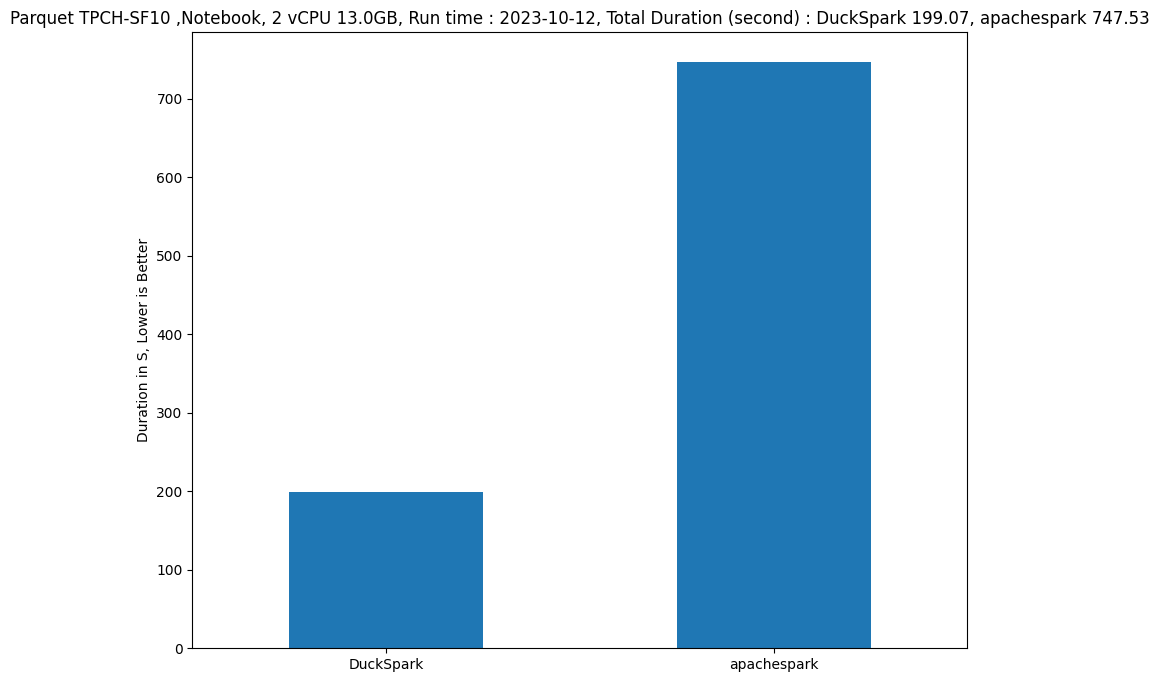

In [ ]:
xx= concat[['DuckSpark','apachespark']].sum()
ax = xx.plot.bar(rot=0,title=runtime,ylabel='Duration in S, Lower is Better',figsize=(10,8))